In [1]:
from pystencils.session import *

# Tutorial 04: Advection Diffusion - Simple finite differences discretization

In this tutorial we demonstrate how to use the discretization layer on top of *pystencils*, that defines how continuous differential operators are discretized. The result of this discretization layer are stencil equations which are used to generated C or CUDA code.

We are going to discretize the [advection diffusion equation](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation) without reaction terms:

In [2]:
domain_size = (200, 80)
dim = len(domain_size)

# create arrays
c_arr = np.zeros(domain_size)
v_arr = np.zeros(domain_size + (dim,))

# create fields
c, v, c_next = ps.fields("c, v(2), c_next: [2d]", c=c_arr, v=v_arr, c_next=c_arr)

# write down advection diffusion pde
# the equation is represented by a single term and an implicit "=0" is assumed.
adv_diff_pde = ps.fd.transient(c) - ps.fd.diffusion(c, sp.Symbol("D")) + ps.fd.advection(c, v)
adv_diff_pde

It describes how the concentration $c$ of a passive substance, which does not influence the flow field, behaves in a fluid with given velocity $v$.
To illustrate the two effects here, image we release a constant stream of dye at some point in a river. The dye is transported with the flow (advection) but also the trace gets wider and wider normal to the flow direction due to diffusion.

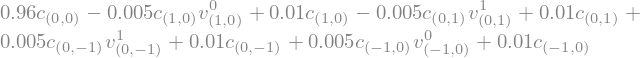

In [3]:
discretize = ps.fd.Discretization2ndOrder(1, 0.01)
discretization = discretize(adv_diff_pde)
discretization.subs(sp.Symbol("D"),1)

In [4]:
ast = ps.create_kernel([ps.Assignment(c_next.center(), discretization.subs(sp.Symbol("D"), 1))])
kernel = ast.compile()

/home/ml/Studium/sfb_empty_pore/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ml/Studium/sfb_empty_pore/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


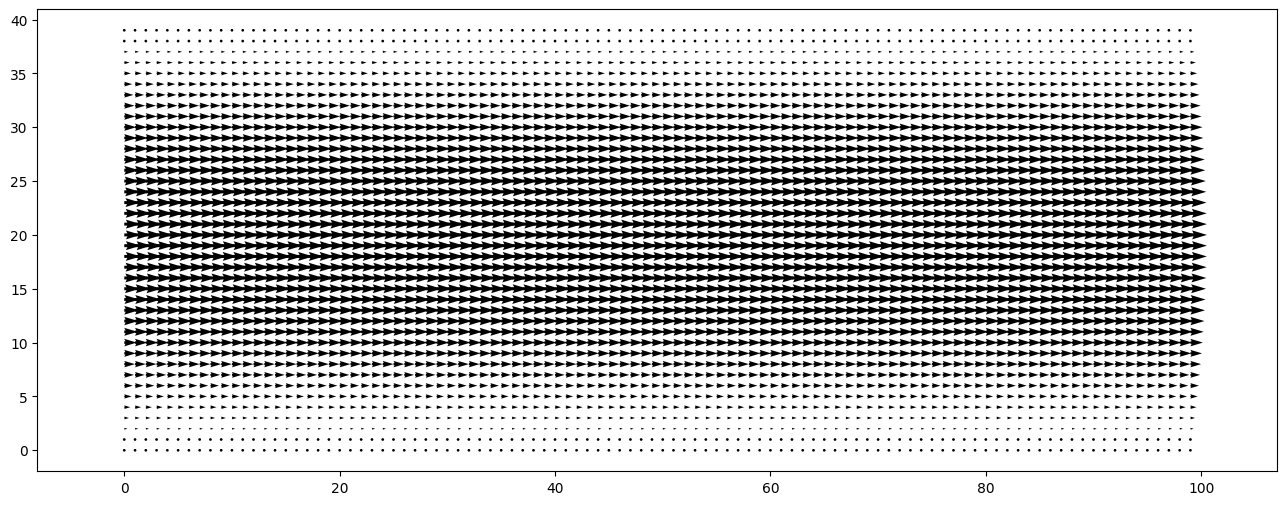

In [5]:
y = np.linspace(0, 1, v_arr.shape[1])
v_arr[:, :, 0] = -y * (y - 1.0) * 5
plt.vector_field(v_arr);

In [6]:
def boundary_handling(c):
    # No concentration at the upper, lower wall and the left inflow border
    c[:, 0] = 0
    c[:, -1] = 0
    c[0, :] = 0
    # At outflow border: neumann boundaries by copying last valid layer
    c[-1, :] = c[-2, :]
    
    # Some source inside the domain
    c[10: 15, 25:30] = 1.0
    c[20: 25, 60:65] = 1.0

c_tmp_arr = np.empty_like(c_arr)
def timeloop(steps=100):
    global c_arr, c_tmp_arr
    for i in range(steps):
        boundary_handling(c_arr)
        kernel(c=c_arr, c_next=c_tmp_arr, v=v_arr)
        c_arr, c_tmp_arr = c_tmp_arr, c_arr
    return c_arr

In [7]:
if 'is_test_run' in globals():
    timeloop(10)
    result = None
else:
    ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=300)
    result = ps.jupyter.display_as_html_video(ani)
result